In [199]:
from sklearn import metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, classification_report, recall_score, f1_score, confusion_matrix, make_scorer, accuracy_score
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_validate 
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SequentialFeatureSelector
from numpy import mean
pd.set_option('display.max_colwidth', -1)


In [31]:
df = pd.read_excel('1 выборка.xlsx')
df.shape

(2282, 22)

quite a high dim data

In [32]:
# prepare X and y

X = df.drop(['Наименование на английском','Банкрот'],axis=1)
cols = X.columns

X = pd.DataFrame(X)
X.columns = cols

y = df['Банкрот']
y = pd.DataFrame(y)
y.columns = ['Банкрот']

In [33]:
Counter(y['Банкрот'])

Counter({0: 2253, 1: 29})

* 'bankrupt' class is coded as 1
* 'this is fine' class (not bankrupts) coded as 0

dataset is highly unbalanced (1:99) so I will use SMOTE algoritm with default settings, otherwise the models would just ignore minor class:
* split dataset into train (80%) and test (20%) sets
* generate new samples of minor class for training data to be balanced (whilte test set remains unchanged)

In [48]:
target_names = ['this is fine', 'bankrupt']

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

### DECISION TREE

I would implement decision tree first to get some insights about whether there might be some more important features

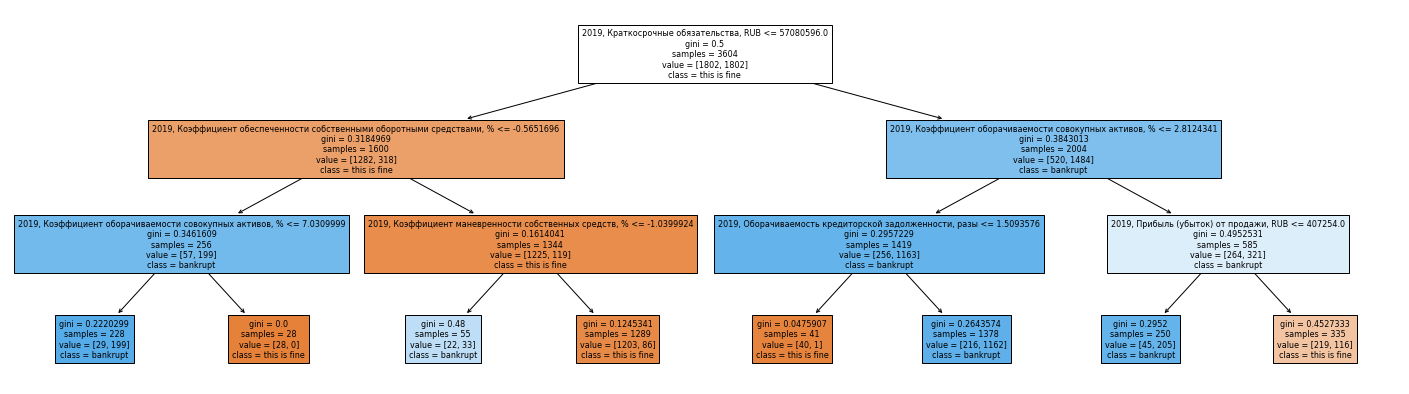

              precision    recall  f1-score   support

this is fine      1.000     0.816     0.899       451
    bankrupt      0.067     1.000     0.126         6

    accuracy                          0.818       457
   macro avg      0.534     0.908     0.512       457
weighted avg      0.988     0.818     0.889       457

[[368  83]
 [  0   6]]


In [53]:
clf = DecisionTreeClassifier(min_samples_leaf=5, max_depth=3)
clf.fit(X_train, y_train)

fig = plt.figure(figsize=(25, 7))
X.feature_names = X.columns

_ = tree.plot_tree(clf, filled=True, feature_names=X.feature_names, class_names=['this is fine', 'bankrupt'], fontsize=8, precision=7)
plt.show()
fig.savefig('tree.pdf')

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, digits=3, target_names=target_names))
print(confusion_matrix(y_test, y_pred))

Recall is very nice for both classes and what is more important: all bankrupts are identified! The problem with decision tree here is that such a result is not stable. Cross validation was not implemented as I just wanted to get the most important features, this list is quite constant

I scale data since there are both absolute and rates values and rest of models is not able to handle unscaled data

In [106]:
scaler = MinMaxScaler()
scaler.fit(X)

X=scaler.transform(X)
X=pd.DataFrame(X)
X.columns = cols
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [151]:
def precision(conf):
    TP = conf[0, 0]
    FP = conf[0, 1]
    FN = conf[1, 0]
    TN = conf[1, 1]
    if (TP + FP) == 0:
        result = 0
    else:
        result = TP / (TP + FP)
    return round(result, 3)


def recall(conf):  # same as sensitivity
    TP = conf[0, 0]
    FP = conf[0, 1]
    FN = conf[1, 0]
    TN = conf[1, 1]
    if (TP + FN) == 0:
        result = 0
    else:    
        result = TP / (TP + FN)
    return round(result, 3)


def specificity(conf):
    TP = conf[0, 0]
    FP = conf[0, 1]
    FN = conf[1, 0]
    TN = conf[1, 1]
    if (TN + FP) == 0:
        result = 0
    else:    
        result = TN / (TN + FP)
    return round(result, 3)

### LOGISTIC REGRESSION

In [156]:
def sfs_compute(clf, X_train, y_train):
    for i in range(1,11):

        sfs = SequentialFeatureSelector(clf, n_features_to_select=i)
        sfs.fit(X_train, y_train)

        new_data = sfs.transform(X_train)

        clf.fit(new_data, y_train)

        new_test = sfs.transform(X_test)
        print('number of factors: ',i)
        print('accuracy: %.3f'% clf.score(new_test, y_test))
    
        y_pred = clf.predict(new_test)
        conf = confusion_matrix(y_test, y_pred)
    
    #print('accuracy: %.3f'% clf.score(new_test, y_test))
        print(conf)
        tn, fp, fn, tp = conf.ravel()
    
        accuracy_result = clf.score(new_test, y_test)
        accuracy_list.append(accuracy_result)
    
        tp_result = tp
        tp_list.append(tp_result)
        precision_result = precision(conf)
        precision_list.append(precision_result)
        recall_result = recall(conf)
        recall_list.append(recall_result)
        specificity_result = specificity(conf)
        specificity_list.append(specificity_result)
        print('')

In [157]:
accuracy_list = []
precision_list = []
specificity_list = []
recall_list = []
tp_list = []
clf = LogisticRegression(random_state=0)
    
sfs_compute(clf, X_train, y_train)

number of factors:  1
accuracy: 0.860
[[391  60]
 [  4   2]]

number of factors:  2
accuracy: 0.877
[[399  52]
 [  4   2]]

number of factors:  3
accuracy: 0.849
[[386  65]
 [  4   2]]

number of factors:  4
accuracy: 0.834
[[377  74]
 [  2   4]]

number of factors:  5
accuracy: 0.827
[[374  77]
 [  2   4]]

number of factors:  6
accuracy: 0.842
[[381  70]
 [  2   4]]

number of factors:  7
accuracy: 0.842
[[381  70]
 [  2   4]]

number of factors:  8
accuracy: 0.842
[[381  70]
 [  2   4]]

number of factors:  9
accuracy: 0.862
[[391  60]
 [  3   3]]

number of factors:  10
accuracy: 0.893
[[406  45]
 [  4   2]]



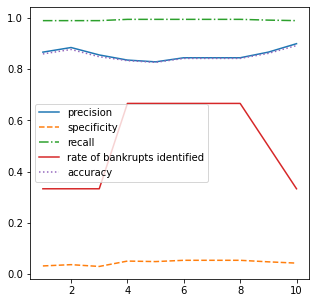

In [158]:
tp_plot = [x / 6 for x in tp_list]
number_of_leafs = list(range(1, 11))
# plot lines
font = {'weight' : 'normal',
        'size'   : 10}

plt.rc('font', **font)
plt.figure(figsize=(5, 5))
plt.plot(number_of_leafs, precision_list, label="precision", linestyle="-")
plt.plot(number_of_leafs, specificity_list, label="specificity", linestyle="--")
plt.plot(number_of_leafs, recall_list, label="recall", linestyle="-.")
plt.plot(number_of_leafs, tp_plot, label="rate of bankrupts identified", linestyle="-")
plt.plot(number_of_leafs, accuracy_list, label="accuracy", linestyle=":")
plt.legend()
plt.show()

as seen on plot 6 features (out of 20) is optimal number for logistic regression, so I would figure out what are these features names

In [183]:
clf = LogisticRegression(random_state=0) #.fit(X, y)

sfs = SequentialFeatureSelector(clf, n_features_to_select=6)
sfs.fit(X_train, y_train)
cols = sfs.get_support(indices=True)
X_important_features = X_train.iloc[:,cols]

In [186]:
clf = LogisticRegression(random_state=0).fit(X_important_features, y_train)
feature_coef = pd.DataFrame(clf.coef_)

In [188]:
feature_coef.columns = X_important_features.columns

In [190]:
feature_coef.T

,0
"2019, Собственный оборотный капитал, RUB",0.734215
"2019, Оборачиваемость кредиторской задолженности, разы",-1.063506
"2019, Коэффициент оборачиваемости совокупных активов, %",-0.816753
"2019, Коэффициент соотношения заемных и собственных средств, %",1.311286
"2019, Коэффициент обеспеченности собственными оборотными средствами, %",-2.141832
"2019, Рентабельность затрат, %",-1.005382


### SUPPORT VECTOR MACHINE
default parameters, same algorithm

In [195]:
clf = LinearSVC(max_iter=10000) 
accuracy_list = []
precision_list = []
specificity_list = []
recall_list = []
tp_list = []
sfs_compute(clf, X_train, y_train)

number of factors:  1
accuracy: 0.867
[[394  57]
 [  4   2]]

number of factors:  2
accuracy: 0.733
[[331 120]
 [  2   4]]

number of factors:  3
accuracy: 0.716
[[323 128]
 [  2   4]]

number of factors:  4
accuracy: 0.888
[[403  48]
 [  3   3]]

number of factors:  5
accuracy: 0.891
[[404  47]
 [  3   3]]

number of factors:  6
accuracy: 0.689
[[310 141]
 [  1   5]]

number of factors:  7
accuracy: 0.853
[[385  66]
 [  1   5]]

number of factors:  8
accuracy: 0.853
[[386  65]
 [  2   4]]

number of factors:  9
accuracy: 0.880
[[399  52]
 [  3   3]]

number of factors:  10
accuracy: 0.617
[[277 174]
 [  1   5]]



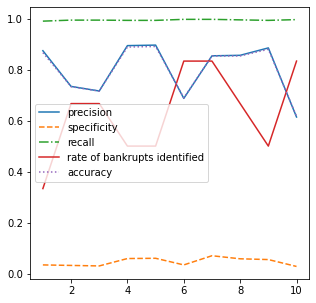

In [196]:
tp_plot = [x / 6 for x in tp_list]
number_of_leafs = list(range(1, 11))
# plot lines
font = {'weight' : 'normal',
        'size'   : 10}

plt.rc('font', **font)
plt.figure(figsize=(5, 5))
plt.plot(number_of_leafs, precision_list, label="precision", linestyle="-")
plt.plot(number_of_leafs, specificity_list, label="specificity", linestyle="--")
plt.plot(number_of_leafs, recall_list, label="recall", linestyle="-.")
plt.plot(number_of_leafs, tp_plot, label="rate of bankrupts identified", linestyle="-")
plt.plot(number_of_leafs, accuracy_list, label="accuracy", linestyle=":")
plt.legend()
plt.show()

In [200]:
sfs = SequentialFeatureSelector(clf, n_features_to_select=7)
sfs.fit(X_train, y_train)
cols = sfs.get_support(indices=True)
important_features = pd.DataFrame(X_train.iloc[:,cols].columns)
important_features

,0
0,"2019, Собственный оборотный капитал, RUB"
1,"2019, Оборачиваемость кредиторской задолженности, разы"
2,"2019, Коэффициент оборачиваемости совокупных активов, %"
3,"2019, Коэффициент соотношения заемных и собственных средств, %"
4,"2019, Коэффициент концентрации собственного капитала (автономии), %"
5,"2019, Рентабельность затрат, %"
6,"2019, Коэффициент текущей ликвидности, %"


5 out of 7 parameters are the same as with logistic regression, some of it intersect with decision tree, showing quite a good consistency of results, but due to train_test_split the coefficients might slightly change